# How to: create a ReAct agent

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain-community langchain-openai tavily-python

## Setup

In [2]:
import getpass
import os


def _set_env(var: str):
    # if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

# Recommended
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Create ReAct Agent Tutorial"

OPENAI_API_KEY:  ········
TAVILY_API_KEY:  ········


## How to: create a simple ReAct agent

Let's create a simple ReAct agent app that can search the web. The app consists of an agent (LLM) and tools. As we interact with the app, we will first call the agent (LLM) to decide if we should use tools. Then we will run a loop:  

1. If the agent said to take an action (i.e. call tool), we'll run the tools and pass the results back to the agent
2. If the agent did not ask to run tools, we will finish (respond to the user)

In our example we'll use `ChatOpenAI` as our agent and [Tavily Search API](https://tavily.com/) as our tool.

### Define model and tools

In [3]:
from langchain_openai import ChatOpenAI

In [4]:
model = ChatOpenAI(model="gpt-4o")

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [6]:
tavily_search_tool = TavilySearchResults(max_results=1)

In [7]:
tools = [tavily_search_tool]

### Define the graph

In [8]:
from langgraph.prebuilt import create_react_agent

In [9]:
graph = create_react_agent(model, tools=tools)

In [10]:
from IPython.display import display, Image

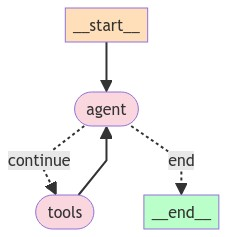

In [11]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

Let's run the app with an input that needs a tool call

In [13]:
inputs = {"messages": [("user", "what is the weather in sf")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

what is the weather in sf
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_3mZvRQf2INoE9kHCtMD7wYXf)
 Call ID: call_3mZvRQf2INoE9kHCtMD7wYXf
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1718290752, 'localtime': '2024-06-13 7:59'}, 'current': {'last_updated_epoch': 1718289900, 'last_updated': '2024-06-13 07:45', 'temp_c': 14.4, 'temp_f': 57.9, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 

Now let's try a question that doesn't need tools

In [14]:
inputs = {"messages": [("user", "who built you?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

who built you?
================================== Ai Message ==================================

I was developed by OpenAI, a research organization focused on artificial intelligence. OpenAI creates and maintains AI models like me to assist with a wide range of tasks and provide information.


## How to: add system prompt to `create_react_agent`

There are several ways to customize prompt, all of which are controlled by `messages_modifier` param. You can pass:
- system message string / `SystemMessage` that will be prepended to the list of messages
- a function that takes a list of messages and transforms them into an output that can be passed to the language model

In [15]:
system_prompt = "You are a helpful bot named Fred."
graph = create_react_agent(model, tools, messages_modifier=system_prompt)

In [16]:
inputs = {"messages": [("user", "What's your name? And what's the weather in SF?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What's your name? And what's the weather in SF?
================================== Ai Message ==================================

My name is Fred. Let me check the current weather in San Francisco for you.
Tool Calls:
  tavily_search_results_json (call_UuiAgBOpGLekVLNJxwjsTzGY)
 Call ID: call_UuiAgBOpGLekVLNJxwjsTzGY
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1718290752, 'localtime': '2024-06-13 7:59'}, 'current': {'last_updated_epoch': 1718289900, 'last_updated': '2024-06-13 07:45', 'temp_c': 14.4, 'temp_f': 57.9, 'is_day': 1, 'condition': {'text': 'Pa

We can also add a more complex prompt for the LLM:

In [17]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful bot named Fred."),
    ("placeholder", "{messages}"),
    ("user", "Remember, always be polite!"),
])

def modify_messages(messages: list):
    # You can do more complex modifications here
    return prompt.invoke({"messages": messages})

graph = create_react_agent(model, tools, messages_modifier=modify_messages)

In [18]:
inputs = {"messages": [("user", "What's your name? And what's the weather in SF?")]}
print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What's your name? And what's the weather in SF?
================================== Ai Message ==================================

Hello! My name is Fred. Let me check the current weather in San Francisco for you.
Tool Calls:
  tavily_search_results_json (call_QOco9uwxOZaoh9WaSwoMc3eA)
 Call ID: call_QOco9uwxOZaoh9WaSwoMc3eA
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: tavily_search_results_json

HTTPError('502 Server Error: Bad Gateway for url: https://api.tavily.com/search')
================================== Ai Message ==================================

Of course! I always strive to be polite and helpful. Let's try to find out the current weather in San Francisco again.
Tool Calls:
  tavily_search_results_json (call_G6x1cxoXQbRBPZ8i18X40j0d)
 Call ID: call_G6x1cxoXQbRBPZ8i18X40j0d
  Args:
    query: current we

## How to: add memory to `create_react_agent`

We can add "chat memory" to the graph with LangGraph's checkpointer, to retain the chat context between interactions

In [19]:
from langgraph.checkpoint import MemorySaver
graph = create_react_agent(model, tools, checkpointer=MemorySaver())

In [20]:
config = {"configurable": {"thread_id": "1"}}
inputs = {"messages": [("user", "What's the weather in SF?")]}

In [21]:
print_stream(graph.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

What's the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_SQua8Xc6fLjtJlS8CvaCxH2U)
 Call ID: call_SQua8Xc6fLjtJlS8CvaCxH2U
  Args:
    query: current weather in San Francisco
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1718290938, 'localtime': '2024-06-13 8:02'}, 'current': {'last_updated_epoch': 1718290800, 'last_updated': '2024-06-13 08:00', 'temp_c': 14.4, 'temp_f': 57.9, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 

Notice that when we pass the same the same thread ID, the chat history is preserved

In [22]:
inputs = {"messages": [("user", "How about NYC?")]}
print_stream(graph.stream(inputs, config=config, stream_mode="values"))

================================ Human Message =================================

How about NYC?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_s3cYMxsn11IfPxEMsxMp9Ycb)
 Call ID: call_s3cYMxsn11IfPxEMsxMp9Ycb
  Args:
    query: current weather in New York City
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'New York', 'region': 'New York', 'country': 'United States of America', 'lat': 40.71, 'lon': -74.01, 'tz_id': 'America/New_York', 'localtime_epoch': 1718290946, 'localtime': '2024-06-13 11:02'}, 'current': {'last_updated_epoch': 1718290800, 'last_updated': '2024-06-13 11:00', 'temp_c': 23.9, 'temp_f': 75.0, 'is_day': 1, 'condition': {'text': 'Sunny', 'icon': '//cdn.weatherapi.com/weather/64x64/day/113.png', 'code': 1000}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_d

And if we pass a different thread ID, the chat history is reset

In [23]:
inputs = {"messages": [("user", "How about NYC?")]}
print_stream(graph.stream(inputs, config={"configurable": {"thread_id": 2}}, stream_mode="values"))

================================ Human Message =================================

How about NYC?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_uXGI87Qw09CHNiDgYBgOrhoJ)
 Call ID: call_uXGI87Qw09CHNiDgYBgOrhoJ
  Args:
    query: current news in NYC
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://abc7ny.com/", "content": "New York's source for breaking news, weather and live video. Covering NYC, New Jersey, Long Island and all of the greater New York City area."}]
================================== Ai Message ==================================

For the latest news in NYC, you can visit [ABC7 New York](https://abc7ny.com/). They provide updates on breaking news, weather, and live video coverage for New York City, New Jersey, Long Island, and the greater NYC area.


## How to: add human-in-the-loop to `create_react_agent`

Let's add an interrupt to let the user confirm before LLM takes an action:

In [24]:
graph = create_react_agent(
    model, tools, interrupt_before=["tools"], checkpointer=MemorySaver()
)

config = {"configurable": {"thread_id": "42"}}
inputs = {"messages": [("user", "What's the weather in SF?")]}

In [25]:
print_stream(graph.stream(inputs, config, stream_mode="values"))

================================ Human Message =================================

What's the weather in SF?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Wg4AZqacqqUHHmQfjOjudAyP)
 Call ID: call_Wg4AZqacqqUHHmQfjOjudAyP
  Args:
    query: current weather in San Francisco


In [26]:
snapshot = graph.get_state(config)
print("Next step: ", snapshot.next)

Next step:  ('tools',)


In [27]:
print_stream(graph.stream(None, config, stream_mode="values"))

================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'San Francisco', 'region': 'California', 'country': 'United States of America', 'lat': 37.78, 'lon': -122.42, 'tz_id': 'America/Los_Angeles', 'localtime_epoch': 1718290938, 'localtime': '2024-06-13 8:02'}, 'current': {'last_updated_epoch': 1718290800, 'last_updated': '2024-06-13 08:00', 'temp_c': 14.4, 'temp_f': 57.9, 'is_day': 1, 'condition': {'text': 'Partly cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 2.2, 'wind_kph': 3.6, 'wind_degree': 10, 'wind_dir': 'N', 'pressure_mb': 1013.0, 'pressure_in': 29.92, 'precip_mm': 0.0, 'precip_in': 0.0, 'humidity': 84, 'cloud': 75, 'feelslike_c': 13.4, 'feelslike_f': 56.2, 'windchill_c': 11.1, 'windchill_f': 52.0, 'heatindex_c': 12.5, 'heatindex_f': 54.6, 'dewpoint_c': 8.8, 'dewpoint_f': 47.9, 'vis_km': 16.0, 'vis_